In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import binned_statistic
from rfpimp import plot_corr_heatmap
from sklearn.metrics import confusion_matrix
from gahaco.features.feature_utils import get_data
from gahaco.features.correlation import select_uncorrelated_features

Using TensorFlow backend.


In [2]:
features_df = pd.read_hdf('/cosma7/data/dp004/dc-cues1/tng_dataframes/merged_dataframe.h5')

In [3]:
features_df = features_df.fillna(-9999)

In [4]:
features_df = features_df.replace([-np.inf, np.inf], 0.)

In [5]:
features_df.columns

Index(['ID_DMO', 'ID_HYDRO', 'M200_HYDRO', 'M200c', 'Rmax', 'R200c', 'Cnfw',
       'Rhosnfw', 'Formation Time', 'Nmergers', 'MassPeak', 'vpeak',
       'N_subhalos', 'VelDisp', 'Vmax', 'Spin', 'fsub_unbound', 'x_offset',
       'HalfmassRad', 'MassInMaxRad', 'env_5', 'env_10', 'x_dmo', 'y_dmo',
       'z_dmo', 'concentration_prada', 'concentration_nfw', 'rho_s',
       'chisq_nfw', 'vel_ani_param', 'total_M_stars', 'x_hydro', 'y_hydro',
       'z_hydro', 'N_gals', 'M_stars'],
      dtype='object')

In [6]:
features_df.to_hdf( '/cosma7/data/dp004/dc-cues1/symgraph_data/simple_data.hdf',
                   key='df', mode='w')

Text(0,0.5,'$\\beta$')

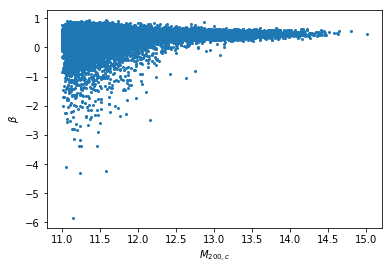

In [7]:
plt.plot(features_df.M200c[features_df.vel_ani_param > -900], 
         features_df.vel_ani_param[features_df.vel_ani_param > -900],
         linestyle='', marker='o', markersize=2)
plt.xlabel('$M_{200,c}$')
plt.ylabel(r'$\beta$')

## Compare stellar mass cut on the central galaxy with dark/luminous
 Could one of the non-central subhalos be the luminous one?


In [8]:
log_m_stars = np.log10(features_df.M_stars)
log_m_stars = log_m_stars.replace([-np.inf, np.inf], 0.)

/cosma/home/dp004/dc-cues1/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
cm = confusion_matrix(features_df.N_gals > 0,
                    log_m_stars > 9,
                     )

In [10]:
cm

array([[ 51369,     48],
       [   205, 155384]])

In [11]:
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


In [12]:
cm

array([[9.99066457e-01, 9.33543381e-04],
       [1.31757386e-03, 9.98682426e-01]])

It seems to be the case, there are 205 cases in which the luminous subhalo is not the central one

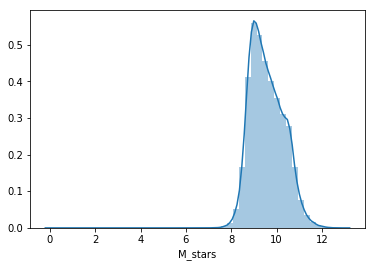

In [13]:
sns.distplot(log_m_stars)

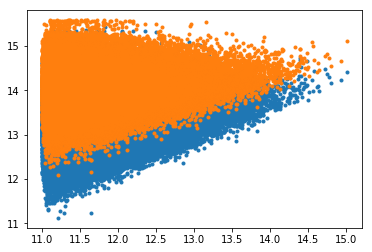

In [14]:
plt.plot(features_df.M200c, features_df.env_5, linestyle='',
          marker='o', markersize=3)
plt.plot(features_df.M200c, features_df.env_10, linestyle='',
          marker='o', markersize=3)

# Check features and their correlations

In [15]:
reduced_df, labels = get_data('stellar_mass')

/cosma/home/dp004/dc-cues1/.local/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
reduced_df.log_Stellar_Mass = labels

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [17]:
features_df.M_stars

0         1.053845e+13
1         5.653562e+12
2         4.906474e+12
3         4.043198e+12
4         4.151962e+12
              ...     
207001    1.380075e+09
207002    2.915731e+09
207003    2.097857e+09
207004    3.313480e+07
207005    1.453808e+08
Name: M_stars, Length: 207006, dtype: float64

Text(0,0.5,'Stellar Mass')

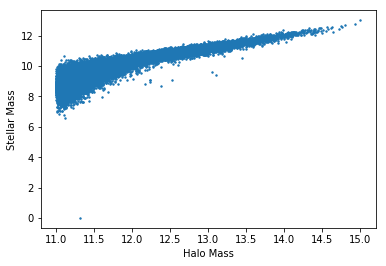

In [18]:
plt.scatter(reduced_df.M200c, labels,
          s=2 )
plt.xlabel('Halo Mass')
plt.ylabel('Stellar Mass')

In [20]:
reduced_df, labels = get_data('dark_or_light')

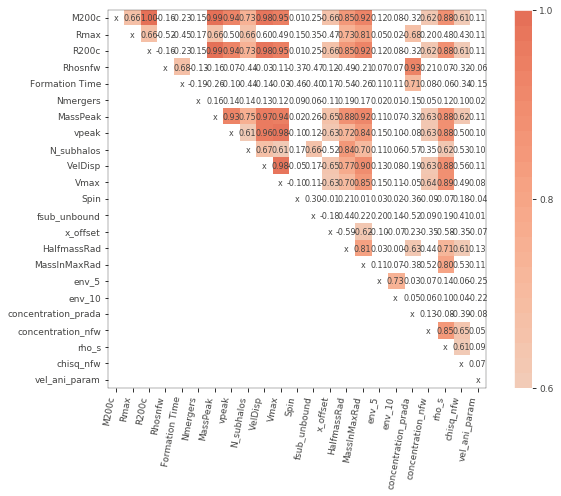

In [21]:
viz = plot_corr_heatmap(reduced_df, figsize=(10,7))


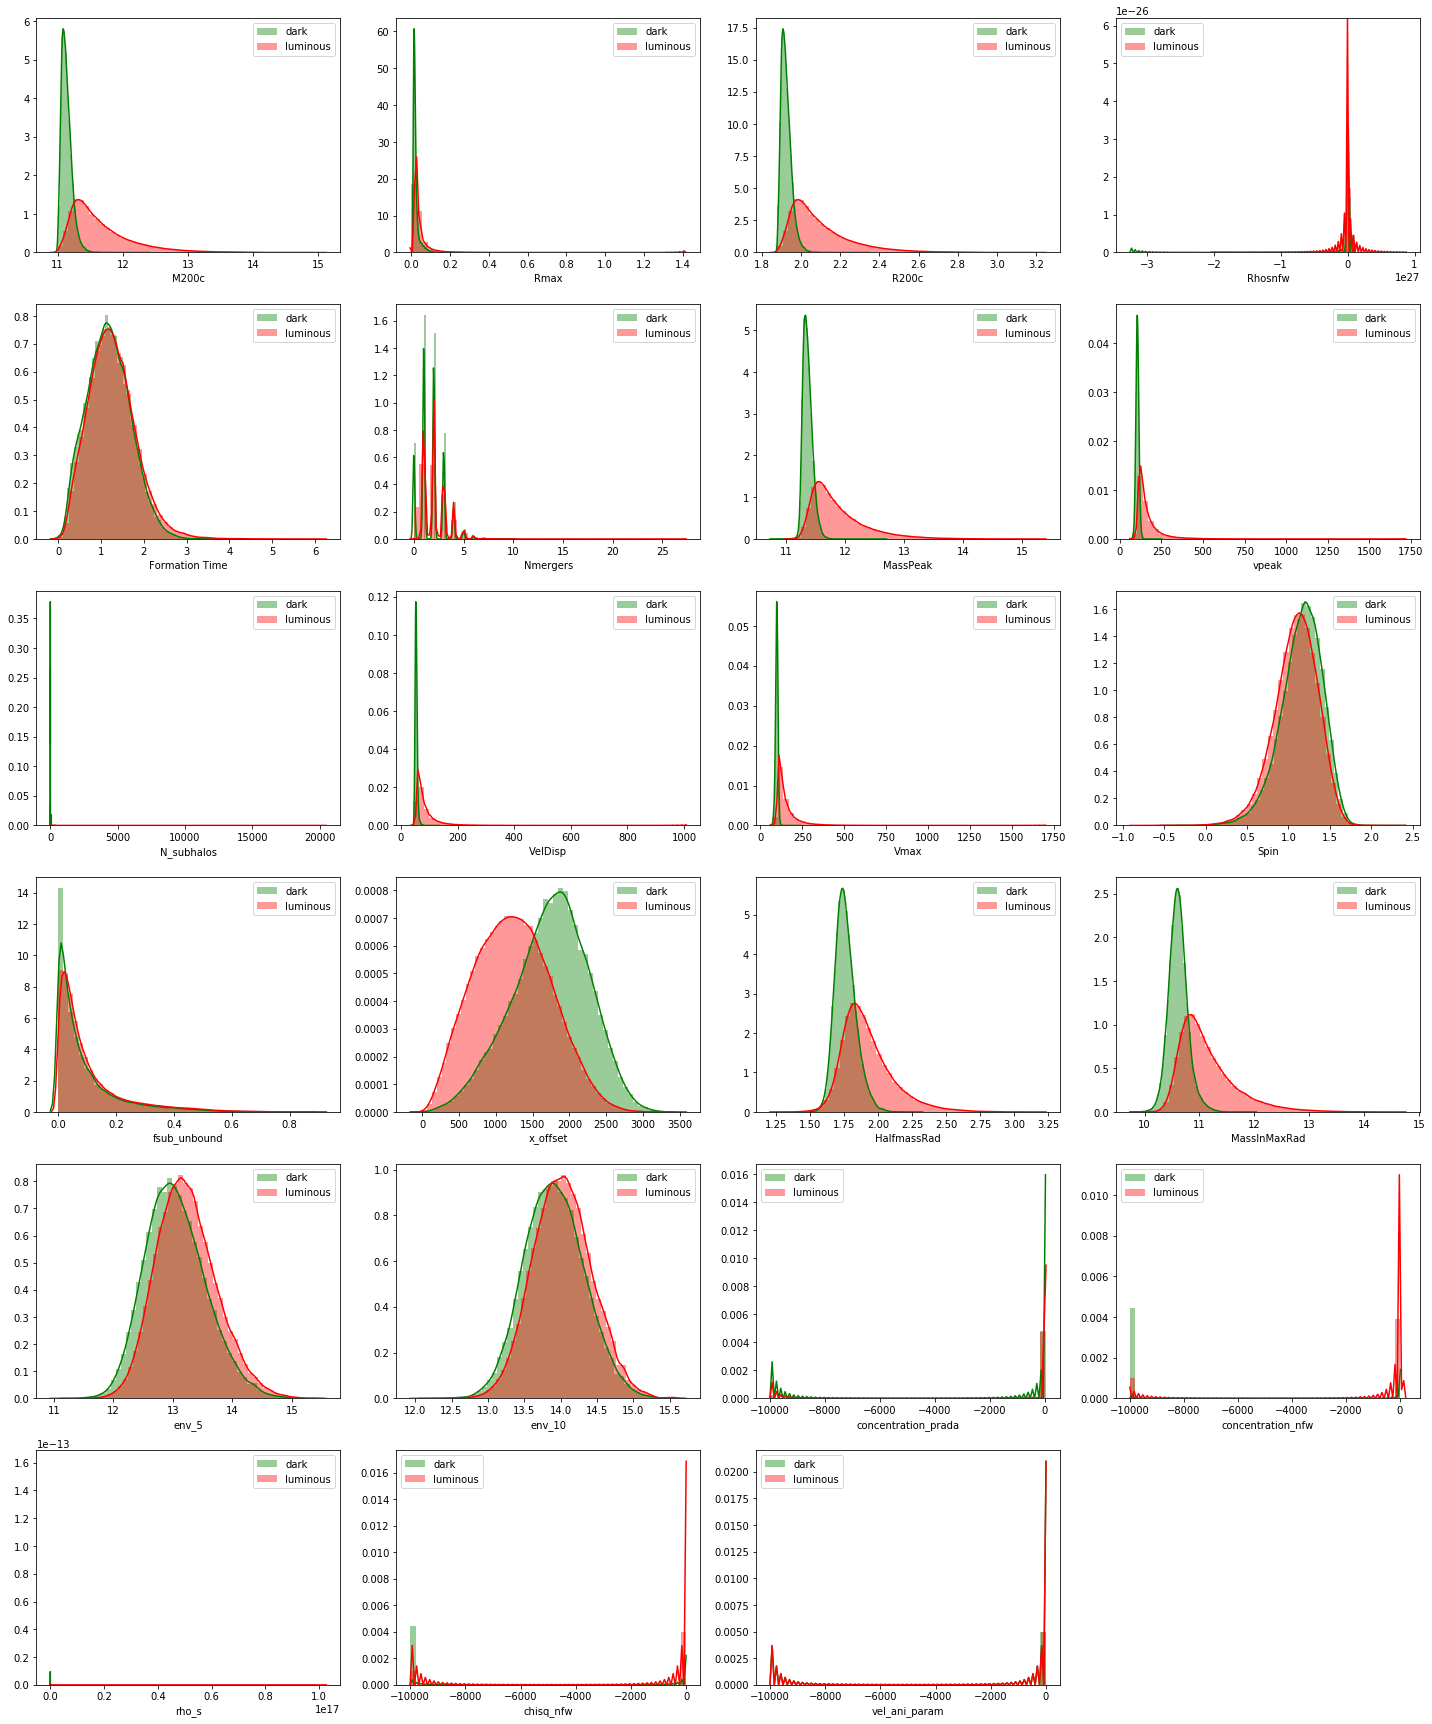

In [22]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in reduced_df.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(reduced_df[i][labels==0],
                 color='g', label = 'dark')
    sns.distplot(reduced_df[i][labels==1],
                 color='r', label = 'luminous')
    plt.legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [23]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict


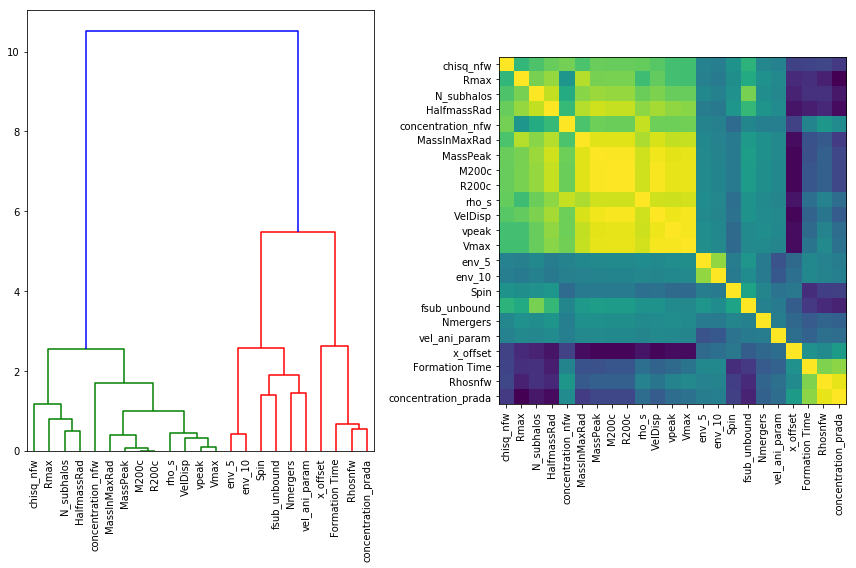

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))


corr = spearmanr(reduced_df).correlation
corr_linkage = hierarchy.ward(corr)

dendro = hierarchy.dendrogram(corr_linkage, labels=reduced_df.columns, ax=ax1,
                              leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))


ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [31]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]



In [32]:
corr = spearmanr(reduced_df[reduced_df.columns[selected_features]]).correlation


In [33]:
len(reduced_df.columns.values)

23

In [34]:
uncorrelated_df = select_uncorrelated_features(reduced_df)

Index(['M200c', 'Rmax', 'R200c', 'Rhosnfw', 'Formation Time', 'Nmergers',
       'MassPeak', 'vpeak', 'N_subhalos', 'VelDisp', 'Vmax', 'Spin',
       'fsub_unbound', 'x_offset', 'HalfmassRad', 'MassInMaxRad', 'env_5',
       'env_10', 'concentration_prada', 'concentration_nfw', 'rho_s',
       'chisq_nfw', 'vel_ani_param'],
      dtype='object')


([<matplotlib.axis.YTick at 0x7f9e74ffb1d0>,
 <a list of 11 Text yticklabel objects>)

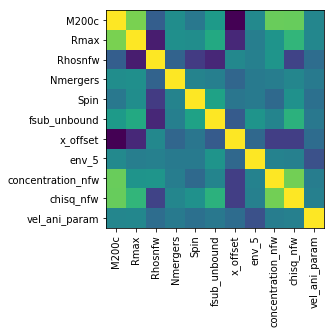

In [35]:
plt.imshow(corr)
plt.xticks(range(len(reduced_df.columns[selected_features].values)),
                 reduced_df.columns[selected_features].values,
           rotation='vertical')

plt.yticks(range(len(reduced_df.columns[selected_features].values)),
                 reduced_df.columns[selected_features].values)

In [37]:
nbins = 30
halo_mass = 10**features_df['M200c']
mass_bins = np.logspace(np.log10(np.min(halo_mass)), np.log10(np.max(halo_mass)), nbins + 1)
mass_c = 0.5 * (mass_bins[1:] + mass_bins[:-1])

mean_gals_per_mass, _, _ = binned_statistic(halo_mass, features_df['N_gals']>0,
                                            statistic = 'mean',
                                            bins=mass_bins)


std_gals_per_mass, _, _ = binned_statistic(halo_mass, features_df['N_gals']>0,
                                            statistic = 'std',
                                            bins=mass_bins)



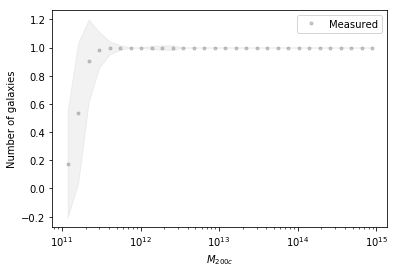

In [41]:
fig = plt.figure()
ax = plt.axes()
ax.plot(mass_c, mean_gals_per_mass,
       linestyle = '', marker = 'o', markersize = 3,
       color = 'gray', alpha = 0.4, label = 'Measured')

ax.fill_between(mass_c, mean_gals_per_mass-std_gals_per_mass,
              mean_gals_per_mass+std_gals_per_mass, alpha = 0.1,
                color='gray')

ax.set_xscale("log")
#ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
plt.legend()

In [38]:
luminous_temporal_order = reduced_df.sort_values('Formation Time')


In [39]:
luminous_youngest = luminous_temporal_order[:int(0.25*len(luminous_temporal_order))]

youngest_mean_gals_per_mass, _, _ = binned_statistic(10**luminous_youngest.M200c,
                                            luminous_youngest['N_gals']>0,
                                            statistic = 'mean',
                                            bins=mass_bins)


youngest_std_gals_per_mass, _, _ = binned_statistic(10**luminous_youngest.M200c,
                                            luminous_youngest['N_gals']>0,
                                            statistic = 'std',
                                            bins=mass_bins)

KeyError: 'N_gals'

In [52]:
luminous_oldest = luminous_temporal_order[-int(0.25*len(luminous_temporal_order)):]

oldest_mean_gals_per_mass, _, _ = binned_statistic(10**luminous_oldest.M200c,
                                            luminous_oldest['N_gals']>0,
                                            statistic = 'mean',
                                            bins=mass_bins)

oldest_std_gals_per_mass, _, _ = binned_statistic(10**luminous_oldest.M200c,
                                            luminous_oldest['N_gals']>0,
                                            statistic = 'std',
                                            bins=mass_bins)

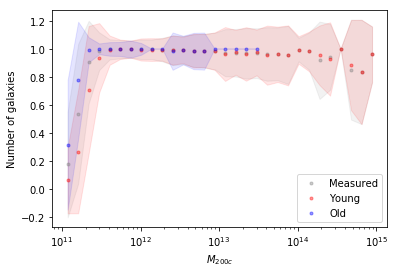

In [54]:
fig = plt.figure()
ax = plt.axes()
ax.plot(mass_c, mean_gals_per_mass,
       linestyle = '', marker = 'o', markersize = 3,
       color = 'gray', alpha = 0.4, label = 'Measured')

ax.fill_between(mass_c, mean_gals_per_mass-std_gals_per_mass,
              mean_gals_per_mass+std_gals_per_mass, alpha = 0.1,
                color='gray')

ax.plot(mass_c, youngest_mean_gals_per_mass,
       linestyle = '', marker = 'o', markersize = 3,
       color = 'red', alpha = 0.4, label = 'Young')

ax.fill_between(mass_c, youngest_mean_gals_per_mass-youngest_std_gals_per_mass,
              youngest_mean_gals_per_mass+youngest_std_gals_per_mass, alpha = 0.1,
               color = 'red')

ax.plot(mass_c, oldest_mean_gals_per_mass,
       linestyle = '', marker = 'o', markersize = 3,
       color = 'blue', alpha = 0.4, label = 'Old')

ax.fill_between(mass_c, oldest_mean_gals_per_mass-oldest_std_gals_per_mass,
              oldest_mean_gals_per_mass+oldest_std_gals_per_mass, alpha = 0.1,
               color = 'blue')

ax.set_xscale("log")
#ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
plt.legend()